In [214]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date, time, datetime 
import numpy as np

In [215]:
circuits = pd.read_csv("data_raw/circuits.csv") 
races = pd.read_csv("data_raw/races.csv")
constructor_standings = pd.read_csv("data_raw/constructor_standings.csv")
constructors = pd.read_csv("data_raw/constructors.csv")

In [216]:

races_circuits = pd.merge(races[["circuitId", "raceId", "date"]],
                          circuits[["circuitId", "name", "alt"]],
                          on='circuitId',
                          how='left')

races_circuits_constructor = pd.merge(races_circuits,
                    constructor_standings[["raceId", "points", "constructorId"]],
                    on="raceId",
                    how='left')

final_df = pd.merge(races_circuits_constructor,
                    constructors[["constructorId", "name"]],
                    on="constructorId",
                    how='left')





In [217]:
final_df["alt_num"] = pd.to_numeric(final_df["alt"], "coerce")
final_df["date_parse"] = pd.to_datetime(final_df["date"], format="%Y-%m-%d")

In [218]:
final_df = final_df.rename(columns={'name_x': 'circuit_name', 'name_y':'constructor_name'})
final_df.dtypes

circuitId                    int64
raceId                       int64
date                        object
circuit_name                object
alt                         object
points                     float64
constructorId              float64
constructor_name            object
alt_num                    float64
date_parse          datetime64[ns]
dtype: object

In [219]:
final_df.groupby("constructor_name").agg(avg_points = ("points", "mean")).sort_values(by="avg_points", ascending=False)

,avg_points
constructor_name,
Mercedes,276.186538
Red Bull,186.742816
Brawn,103.058824
Lotus F1,97.207792
Ferrari,89.046397
...,...
Gilby,0.000000
Merzario,0.000000
HRT,0.000000


In [229]:
mercedes = final_df.query("constructor_name == 'Mercedes'")
mercedes_agg = (mercedes.groupby("circuit_name")
                        .agg(avg_points = ("points", "mean"), 
                             avg_alt = ("alt_num", "mean"))
                        .sort_values(by="avg_alt", ascending=True))

In [230]:
mercedes_agg["diff_points"] = mercedes_agg["avg_points"].diff()
mercedes_agg["lag_points"]    = mercedes_agg["avg_points"].shift(1)
mercedes_agg["growth_points"] = mercedes_agg["diff_points"]* 100/mercedes_agg["lag_points"]


In [231]:
mercedes_agg.replace([np.inf, -np.inf], np.nan, inplace=True)
mercedes_agg.dropna(inplace=True)

In [232]:
mercedes_agg.describe()

,avg_points,avg_alt,diff_points,lag_points,growth_points
count,31.000000,31.000000,31.000000,31.000000,31.000000
mean,273.803229,223.548387,12.765745,261.037484,36.542355
std,133.985065,427.062278,157.808960,122.270760,123.343986
min,28.545455,0.000000,-434.858974,28.545455,-83.435417
25%,184.477273,8.500000,-78.355020,183.416667,-22.536010
50%,265.875000,103.000000,0.166667,255.750000,0.090909
75%,342.221154,224.500000,127.147727,332.096154,66.390560
max,579.071429,2227.000000,264.435714,521.192308,549.681529


In [233]:
u = mercedes_agg['growth_points'].mean()
sd = mercedes_agg['growth_points'].std()

In [235]:
mercedes_agg['z_score'] = abs((mercedes_agg['growth_points']-u)/sd)
mercedes_filter = mercedes_agg.query("z_score <= 3")
# mercedes_plot = mercedes_filter.groupby('avg_alt').agg(median_point_growth = ("growth_points", "std"))

In [239]:
mercedes_filter.describe()

,avg_points,avg_alt,diff_points,lag_points,growth_points,z_score
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,276.748185,230.566667,7.960967,268.787218,19.437716,0.508999
std,135.251267,432.540904,158.183673,116.360004,79.724374,0.411897
min,28.545455,0.000000,-434.858974,82.200000,-83.435417,0.056697
25%,187.125000,7.750000,-91.119068,183.988636,-25.244249,0.269051
50%,266.937500,105.500000,-1.983333,260.812500,-2.348368,0.430616
75%,343.735577,239.750000,124.969952,335.644231,55.493341,0.627663
max,579.071429,2227.000000,264.435714,521.192308,320.012165,2.298205


Text(0.5, 1.0, 'Growth of points by altitude')

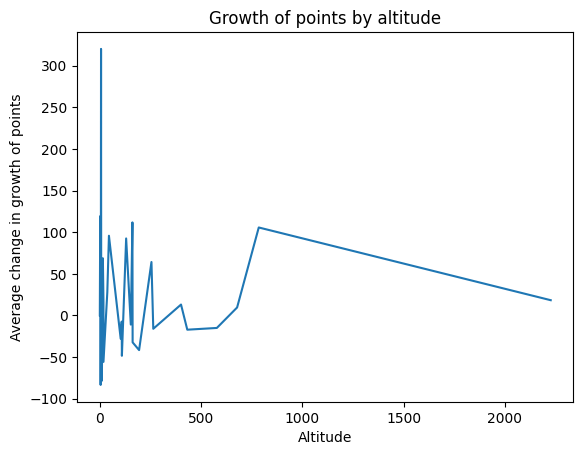

In [241]:
plt.plot("avg_alt", "growth_points", data=mercedes_filter)
plt.xlabel("Altitude")
plt.ylabel("Average change in growth of points")
plt.title("Growth of points by altitude")